In [1]:
import os
import numpy as np
import tensorflow as tf
from PIL import Image, ImageDraw, ImageFont
import matplotlib.pyplot as plt
import wandb
import pandas as pd

In [2]:
print("Num GPUs Available:", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available: 0


In [3]:
wandb.login()
api = wandb.Api()
artifact = api.artifact('rueedi-tobias-hochschule-luzern/Own CNN/cnn-model:v16', type='model')
model_path = artifact.download()

for file in os.listdir(model_path):
    if file.endswith(".h5") or file.endswith(".keras"):
        model_g20 = tf.keras.models.load_model(os.path.join(model_path, file), compile=False)
        model_g20.trainable = False
        break

artifact = api.artifact('rueedi-tobias-hochschule-luzern/Own CNN/cnn-model:v13', type='model')
model_path = artifact.download()

for file in os.listdir(model_path):
    if file.endswith(".h5") or file.endswith(".keras"):
        model_g10 = tf.keras.models.load_model(os.path.join(model_path, file), compile=False)
        model_g10.trainable = False
        break

artifact = api.artifact('rueedi-tobias-hochschule-luzern/Own CNN/cnn-model:v15', type='model')
model_path = artifact.download()

for file in os.listdir(model_path):
    if file.endswith(".h5") or file.endswith(".keras"):
        model_g5 = tf.keras.models.load_model(os.path.join(model_path, file), compile=False)
        model_g5.trainable = False
        break



wandb: Currently logged in as: samutheman (rueedi-tobias-hochschule-luzern) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin
wandb: Downloading large artifact cnn-model:v16, 80.25MB. 1 files... 
wandb:   1 of 1 files downloaded.  
Done. 0:0:0.8 (95.1MB/s)
wandb: Downloading large artifact cnn-model:v13, 80.25MB. 1 files... 
wandb:   1 of 1 files downloaded.  
Done. 0:0:1.0 (83.2MB/s)
wandb: Downloading large artifact cnn-model:v15, 72.53MB. 1 files... 
wandb:   1 of 1 files downloaded.  
Done. 0:0:0.7 (108.6MB/s)


In [4]:
# --- Parameters (tweak these to your dataset) ---
IMG_SIZE    = 640
GRID_SIZE   = 10
NUM_CLASSES = 1   #
NUM_BOXES   = 3    # number of anchors per cell
OUTPUT_SHAPE = (GRID_SIZE, GRID_SIZE, NUM_BOXES * (5 + NUM_CLASSES))

In [5]:
# --- YOLO loss with binary class ---
def yolo_loss(y_true, y_pred):
    # reshape to (..., S, S, B, 5 + C)
    pred = tf.reshape(y_pred, (-1, GRID_SIZE, GRID_SIZE, NUM_BOXES, 5 + NUM_CLASSES))
    true = tf.reshape(y_true, (-1, GRID_SIZE, GRID_SIZE, NUM_BOXES, 5 + NUM_CLASSES))
    obj_mask = true[..., 4:5]

    # localization losses
    xy_loss = tf.reduce_sum(obj_mask * tf.square(true[..., 0:2] - pred[..., 0:2]))
    wh_loss = tf.reduce_sum(obj_mask * tf.square(
        tf.sqrt(true[..., 2:4] + 1e-6) - tf.sqrt(pred[..., 2:4] + 1e-6)
    ))

    # objectness and class losses
    obj_loss = tf.reduce_sum(
        tf.keras.losses.binary_crossentropy(true[..., 4:5], pred[..., 4:5])
    )
    class_bce = tf.keras.losses.binary_crossentropy(true[..., 5:], pred[..., 5:])
    class_bce = tf.expand_dims(class_bce, axis=-1)
    class_loss = tf.reduce_sum(obj_mask * class_bce)

    return xy_loss + wh_loss + obj_loss + class_loss

In [6]:
def area_difference_loss(y_true, y_pred):

    pred = tf.reshape(y_pred, (-1, GRID_SIZE, GRID_SIZE, NUM_BOXES, 5 + NUM_CLASSES))
    true = tf.reshape(y_true, (-1, GRID_SIZE, GRID_SIZE, NUM_BOXES, 5 + NUM_CLASSES))


    pred_area = pred[..., 2] * pred[..., 3] * pred[..., 4]
    true_area = true[..., 2] * true[..., 3] * true[..., 4]


    total_pred_area = tf.reduce_sum(pred_area)
    total_true_area = tf.reduce_sum(true_area)


    return tf.abs(total_pred_area - total_true_area)

In [7]:
def combined_yolo_area_loss(y_true, y_pred, area_weight=0.01):

    yolo = yolo_loss(y_true, y_pred)

    area = area_difference_loss(y_true, y_pred)

    return yolo + area_weight * area

In [8]:
def get_gt_boxes_from_csv(csv_path, image_paths):
    """
    Loads ground truth boxes from CSV and normalizes them using the actual image size.
    Assumes CSV columns: image, x1, y1, x2, y2 (pixel coordinates).
    Returns: list of lists of [ymin, xmin, ymax, xmax] in [0,1] for each image in image_paths.
    """
    df = pd.read_csv(csv_path)
    gt_dict = {}
    for _, row in df.iterrows():
        fname = row['image']
        # Find the full path for this image
        img_path = None
        for p in image_paths:
            if os.path.basename(p) == fname:
                img_path = p
                break
        if img_path is None or not os.path.exists(img_path):
            continue
        with Image.open(img_path) as img:
            w, h = img.size
        # CSV columns: x1, y1, x2, y2 (pixel)
        box = [row['y1']/h, row['x1']/w, row['y2']/h, row['x2']/w]
        if fname not in gt_dict:
            gt_dict[fname] = []
        gt_dict[fname].append(box)
    gt_boxes_list = []
    for path in image_paths:
        fname = os.path.basename(path)
        gt_boxes = gt_dict.get(fname, [])
        gt_boxes_list.append(gt_boxes)
    return gt_boxes_list

In [9]:
def compute_iou(box1, box2):
    y1_min, x1_min, y1_max, x1_max = box1
    y2_min, x2_min, y2_max, x2_max = box2

    inter_x_min = max(x1_min, x2_min)
    inter_y_min = max(y1_min, y2_min)
    inter_x_max = min(x1_max, x2_max)
    inter_y_max = min(y1_max, y2_max)

    inter_w = max(0, inter_x_max - inter_x_min)
    inter_h = max(0, inter_y_max - inter_y_min)
    inter_area = inter_w * inter_h

    area1 = (x1_max - x1_min) * (y1_max - y1_min)
    area2 = (x2_max - x2_min) * (y2_max - y2_min)
    union_area = area1 + area2 - inter_area

    return inter_area / union_area if union_area > 0 else 0.0

In [10]:
def average_precision(pred_boxes, gt_boxes, iou_threshold=0.5):
    if len(pred_boxes) == 0:
        return 0.0
    matched = set()
    tp = 0
    for pb in pred_boxes:
        for i, gb in enumerate(gt_boxes):
            if i in matched:
                continue
            if compute_iou(pb, gb) >= iou_threshold:
                tp += 1
                matched.add(i)
                break
    fp = len(pred_boxes) - tp
    fn = len(gt_boxes) - tp
    precision = tp / (tp + fp + 1e-8)
    recall = tp / (tp + fn + 1e-8)
    #print(f"Pred: {pb} matched with GT {i} → IoU = {compute_iou(pb, gb)}")
    return precision 

In [11]:

def mean_average_precision(pred_boxes_list, gt_boxes_list, iou_threshold=0.5):
    aps = []
    for pred_boxes, gt_boxes in zip(pred_boxes_list, gt_boxes_list):
        ap = average_precision(pred_boxes, gt_boxes, iou_threshold)
        aps.append(ap)
    return np.mean(aps)

In [12]:
def ensemble_yolo_outputs(pred1, pred2, weights=(0.4, 0.4, 0.2)):
    """
    Averages YOLO grid outputs from 3 models with specified weights.
    Each pred has shape: [GRID, GRID, NUM_BOXES, 5 + NUM_CLASSES]
    """
    # Ensure the shape is identical
    assert pred1.shape == pred2.shape 

    # Weighted average across predictions
    return (
        weights[0] * pred1 +
        weights[1] * pred2 
    )


In [13]:
def apply_nms(pred_grid, conf_thresh=0.3, iou_thresh=0.4):
    boxes = []
    scores = []

    grid_y, grid_x, num_boxes = pred_grid.shape[:3]

    for gy in range(grid_y):
        for gx in range(grid_x):
            for b in range(num_boxes):
                pred = pred_grid[gy, gx, b]
                conf = pred[4]
                if conf < conf_thresh:
                    continue

                x, y, w, h = pred[:4]
                cx = (gx + x) / grid_x
                cy = (gy + y) / grid_y
                xmin = cx - w / 2
                ymin = cy - h / 2
                xmax = cx + w / 2
                ymax = cy + h / 2

                boxes.append([ymin, xmin, ymax, xmax])
                scores.append(conf)

    if not boxes:
        return [], []

    boxes = tf.constant(boxes, dtype=tf.float32)
    scores = tf.constant(scores, dtype=tf.float32)

    selected_indices = tf.image.non_max_suppression(
        boxes,
        scores,
        max_output_size=10,
        iou_threshold=iou_thresh,
        score_threshold=conf_thresh
    )

    selected_boxes = tf.gather(boxes, selected_indices).numpy()
    selected_scores = tf.gather(scores, selected_indices).numpy()

    return selected_boxes, selected_scores

In [14]:
def decode_yolo_output(pred_grid, conf_thresh=0.3):
    boxes = []
    scores = []

    grid_y, grid_x, num_boxes = pred_grid.shape[:3]

    for gy in range(grid_y):
        for gx in range(grid_x):
            for b in range(num_boxes):
                pred = pred_grid[gy, gx, b]
                conf = pred[4]
                if conf < conf_thresh:
                    continue

                x, y, w, h = pred[:4]
                cx = (gx + x) / grid_x
                cy = (gy + y) / grid_y
                xmin = cx - w / 2
                ymin = cy - h / 2
                xmax = cx + w / 2
                ymax = cy + h / 2

                boxes.append([ymin, xmin, ymax, xmax])
                scores.append(conf)

    return boxes, scores


In [15]:
def ensemble_three_models_on_metric(models, image, conf_thresh=0.3, iou_thresh=0.4):
    all_boxes = []
    all_scores = []

    for model in models:
        pred = model.predict(np.expand_dims(image, axis=0), verbose=0)[0]
        boxes, scores = decode_yolo_output(pred, conf_thresh)
        all_boxes.extend(boxes)
        all_scores.extend(scores)

    if not all_boxes:
        return [], []

    # Ensure numpy arrays are float32
    all_boxes = np.array(all_boxes, dtype=np.float32)
    all_scores = np.array(all_scores, dtype=np.float32)

    boxes = tf.constant(all_boxes, dtype=tf.float32)
    scores = tf.constant(all_scores, dtype=tf.float32)

    selected_indices = tf.image.non_max_suppression(
        boxes=boxes,
        scores=scores,
        max_output_size=20,
        iou_threshold=tf.constant(iou_thresh, dtype=tf.float32),
        score_threshold=tf.constant(conf_thresh, dtype=tf.float32)
    )

    final_boxes = tf.gather(boxes, selected_indices).numpy()
    final_scores = tf.gather(scores, selected_indices).numpy()
    return final_boxes, final_scores


In [16]:
def ensemble_three_models_on_image(models, image, conf_thresh=0.3, iou_thresh=0.4):
    all_boxes = []
    all_scores = []

    for model in models:
        pred = model.predict(np.expand_dims(image, axis=0))[0]
        boxes, scores = decode_yolo_output(pred, conf_thresh)
        all_boxes.extend(boxes)
        all_scores.extend(scores)

    if not all_boxes:
        return [], []

    # Final NMS across all predictions
    boxes = tf.constant(all_boxes, dtype=tf.float32)
    scores = tf.constant(all_scores, dtype=tf.float32)

    selected_indices = tf.image.non_max_suppression(
    boxes=boxes,
    scores=scores,
    max_output_size=20,
    iou_threshold=0.25,       # more aggressive
    score_threshold=0.4       # optional boost
)


    final_boxes = tf.gather(boxes, selected_indices).numpy()
    final_scores = tf.gather(scores, selected_indices).numpy()
    return final_boxes, final_scores


In [17]:
def evaluate_ensemble_on_testset(model1, model2, test_ds, loss_fn, weights=(0.5, 0.5)):
    total_loss = 0.0
    num_batches = 0

    for batch in test_ds:
        images, labels = batch
        pred1 = model1.predict(images)
        pred2 = model2.predict(images)
        # Ensemble: shape [B, GRID, GRID, 3, 6]
        combined_pred = (
            weights[0] * pred1 +
            weights[1] * pred2 
        )

        # Evaluate batch loss
        loss = loss_fn(labels, combined_pred)
        total_loss += loss.numpy()
        num_batches += 1

    avg_loss = total_loss / num_batches
    print(f"Ensemble {loss_fn.__name__} on test set: {avg_loss:.4f}")
    return avg_loss


In [18]:
def parse_tfrecord(example_proto):
    features = {
        "image_raw": tf.io.FixedLenFeature([], tf.string),
        "label_raw": tf.io.FixedLenFeature([], tf.string),
        "filename": tf.io.FixedLenFeature([], tf.string)
    }
    parsed = tf.io.parse_single_example(example_proto, features)
    image = tf.io.decode_jpeg(parsed["image_raw"], channels=3)
    image = tf.image.convert_image_dtype(image, tf.float32)
    label = tf.io.parse_tensor(parsed["label_raw"], out_type=tf.float32)
    label = tf.ensure_shape(label, [GRID_SIZE, GRID_SIZE, NUM_BOXES, 5 + NUM_CLASSES])
    return image, label

def load_test_dataset_from_tfrecord(tfrecord_path, batch_size=4):
    ds = tf.data.TFRecordDataset(tfrecord_path)
    ds = ds.map(parse_tfrecord)
    return ds.batch(batch_size)


In [19]:
def load_images_from_folder(folder_path, num_images=None, target_size=(640, 640)):
    image_paths = [os.path.join(folder_path, f)
                   for f in os.listdir(folder_path)
                   if f.lower().endswith((".jpg", ".jpeg", ".png"))]
    image_paths = sorted(image_paths)
    if num_images:
        image_paths = image_paths[:num_images]
    images = []
    originals = []
    for path in image_paths:
        img = Image.open(path).convert("RGB")
        originals.append(img.copy())
        img_resized = img.resize(target_size)
        img_array = np.array(img_resized) / 255.0
        images.append(img_array)
    print(f"Loaded {len(images)} image(s) from: {folder_path}")
    return np.array(images), originals, image_paths

In [20]:
def get_image_paths_from_folder(folder_path, extensions=(".jpg", ".jpeg", ".png")):
    """
    Returns a sorted list of image file paths from the given folder.
    """
    image_paths = [os.path.join(folder_path, f)
                   for f in os.listdir(folder_path)
                   if f.lower().endswith(extensions)]
    image_paths = sorted(image_paths)
    return image_paths


test_set_path = r"C:\Users\samue\OneDrive\AIML\FS2025\DSPRO\Testset\Images\test_images_SID03\test"

image_paths = get_image_paths_from_folder(test_set_path)

In [21]:
def draw_ensemble_boxes_on_image(original_image, boxes, color="purple", label="Ensemble"):
    """
    Draws bounding boxes from ensemble prediction on a PIL image and displays it.
    Args:
        original_image: PIL.Image (will not be modified in-place)
        boxes: list or np.array of [ymin, xmin, ymax, xmax] in relative coords (0–1)
        color: box color (default: "purple")
        label: label text for each box
    """
    image = original_image.copy()
    draw = ImageDraw.Draw(image)
    try:
        font = ImageFont.truetype("arial.ttf", 20)
    except:
        font = ImageFont.load_default()
    w, h = image.size

    for box in boxes:
        ymin, xmin, ymax, xmax = box
        x1, y1 = int(xmin * w), int(ymin * h)
        x2, y2 = int(xmax * w), int(ymax * h)
        draw.rectangle([x1, y1, x2, y2], outline=color, width=10)
        draw.text((x1 + 4, y1 - 10), label, fill=color, font=font)

    plt.figure(figsize=(6, 6))
    plt.imshow(image)
    plt.title("Ensemble Prediction")
    plt.axis("off")
    plt.show()

In [22]:
def area_coverage_score(pred_boxes, gt_boxes):
    """
    Returns a score from 0 to 100 based on how well the predicted boxes cover the ground truth boxes.
    Full coverage (prediction area == label area) gives 100.
    Over-prediction (prediction area > label area) is penalized.
    Under-prediction (prediction area < label area) is also penalized.
    Args:
        pred_boxes: list or np.array of [ymin, xmin, ymax, xmax] (normalized 0-1)
        gt_boxes: list or np.array of [ymin, xmin, ymax, xmax] (normalized 0-1)
    Returns:
        float: score between 0 and 100
    """
    def total_area(boxes):
        if len(boxes) == 0:
            return 0.0
        boxes = np.array(boxes)
        heights = np.clip(boxes[:, 2] - boxes[:, 0], 0, 1)
        widths = np.clip(boxes[:, 3] - boxes[:, 1], 0, 1)
        return np.sum(heights * widths)

    area_pred = total_area(pred_boxes)
    area_gt = total_area(gt_boxes)

    if area_gt == 0:
        return 0.0 if area_pred > 0 else 100.0

    # Score is 100 if areas match, penalized for over/under
    ratio = area_pred / area_gt
    if ratio <= 1:
        score = ratio * 100
    else:
        # Over-prediction: penalize more as prediction exceeds label
        score = max(0, 100 - (ratio - 1) * 100)
    return score

In [23]:
def overlay_boxes_on_image(original_image, boxes, color=(255, 0, 0), alpha=0.4):
    """
    Overlays colored (transparent) regions for each box on a PIL image.
    Args:
        original_image: PIL.Image (will not be modified in-place)
        boxes: list or np.array of [ymin, xmin, ymax, xmax] in relative coords (0–1)
        color: RGB tuple for overlay color (default: red)
        alpha: transparency (0=transparent, 1=opaque)
    Returns:
        PIL.Image with overlay
    """
    image = original_image.convert("RGBA")
    overlay = Image.new("RGBA", image.size, (0, 0, 0, 0))
    draw = ImageDraw.Draw(overlay)
    w, h = image.size

    for box in boxes:
        ymin, xmin, ymax, xmax = box
        x1, y1 = int(xmin * w), int(ymin * h)
        x2, y2 = int(xmax * w), int(ymax * h)
        draw.rectangle([x1, y1, x2, y2], fill=color + (int(255 * alpha),))

    combined = Image.alpha_composite(image, overlay)
    return combined.convert("RGB")

In [24]:
def area_coverage_score_unique(pred_boxes, gt_boxes, mask_size=512):
    """
    Computes area coverage score where overlapping predicted areas are counted only once.
    Uses binary masks to calculate union area.
    """
    def boxes_to_mask(boxes, size):
        mask = np.zeros((size, size), dtype=np.uint8)
        for y1, x1, y2, x2 in boxes:
            r1 = int(np.clip(y1 * size, 0, size))
            c1 = int(np.clip(x1 * size, 0, size))
            r2 = int(np.clip(y2 * size, 0, size))
            c2 = int(np.clip(x2 * size, 0, size))
            mask[r1:r2, c1:c2] = 1
        return mask

    if len(pred_boxes) == 0 and len(gt_boxes) == 0:
        return 100.0  # perfect match (nothing expected, nothing predicted)
    
    pred_mask = boxes_to_mask(pred_boxes, mask_size)
    gt_mask = boxes_to_mask(gt_boxes, mask_size)

    pred_area = np.sum(pred_mask)
    gt_area = np.sum(gt_mask)

    if gt_area == 0:
        return 0.0 if pred_area > 0 else 100.0

    ratio = pred_area / gt_area
    if ratio <= 1:
        score = ratio * 100
    else:
        score = max(0, 100 - (ratio - 1) * 100)

    return score


In [25]:
def raad_score(pred_boxes, gt_boxes, epsilon=1e-6):
    """
    Computes RAAD: Relative Absolute Area Difference.
    Boxes must be in [ymin, xmin, ymax, xmax] format and normalized to [0, 1].
    """
    def total_area(boxes):
        if len(boxes) == 0:
            return 0.0
        boxes = np.array(boxes)
        heights = np.clip(boxes[:, 2] - boxes[:, 0], 0, 1)
        widths = np.clip(boxes[:, 3] - boxes[:, 1], 0, 1)
        return np.sum(heights * widths)

    area_pred = total_area(pred_boxes)
    area_gt = total_area(gt_boxes)

    raad = abs(area_pred - area_gt) / max(area_gt, epsilon)
    return raad


In [26]:
def raad_score_unique(pred_boxes, gt_boxes, mask_size=512, epsilon=1e-6):
    """
    Computes RAAD using non-overlapping prediction area (via binary mask).
    Overlapping predicted regions are counted only once.
    """
    def boxes_to_mask(boxes, size):
        mask = np.zeros((size, size), dtype=np.uint8)
        for y1, x1, y2, x2 in boxes:
            r1 = int(np.clip(y1 * size, 0, size))
            c1 = int(np.clip(x1 * size, 0, size))
            r2 = int(np.clip(y2 * size, 0, size))
            c2 = int(np.clip(x2 * size, 0, size))
            mask[r1:r2, c1:c2] = 1
        return mask

    pred_mask = boxes_to_mask(pred_boxes, mask_size)
    gt_mask = boxes_to_mask(gt_boxes, mask_size)

    area_pred = float(np.sum(pred_mask))
    area_gt = float(np.sum(gt_mask))

    raad = abs(area_pred - area_gt) / max(area_gt, epsilon)
    return raad


In [27]:
csv_path = r"C:\Users\samue\OneDrive\AIML\FS2025\DSPRO\Testset\bboxes_test.csv"

In [28]:
image_paths_raw = get_image_paths_from_folder(test_set_path)

In [29]:
gt_boxes_list = get_gt_boxes_from_csv(csv_path, image_paths_raw)

# Print the first 5 image filenames and their ground truth boxes
for i in range(min(5, len(image_paths))):
    print(f"{os.path.basename(image_paths[i])}: {gt_boxes_list[i]}")

DSC00028.jpg: [[0.385, 0.5413333333333333, 0.512, 0.5953333333333334], [0.479, 0.574, 0.529, 0.642]]
DSC00045.jpg: [[0.393, 0.526, 0.421, 0.656]]
DSC00050.jpg: [[0.414, 0.5526666666666666, 0.424, 0.664], [0.408, 0.6213333333333333, 0.467, 0.714], [0.437, 0.6906666666666667, 0.507, 0.7333333333333333], [0.44, 0.42866666666666664, 0.472, 0.566], [0.433, 0.516, 0.481, 0.6893333333333334], [0.461, 0.6573333333333333, 0.562, 0.7313333333333333], [0.672, 0.7453333333333333, 0.787, 0.7633333333333333]]
DSC00088.jpg: [[0.559, 0.5786666666666667, 0.583, 0.6493333333333333], [0.638, 0.49666666666666665, 0.647, 0.5466666666666666], [0.569, 0.5446666666666666, 0.58, 0.592]]
DSC00100.jpg: [[0.438, 0.43066666666666664, 0.786, 0.5546666666666666]]


In [30]:
gt_boxes_list_raw = get_gt_boxes_from_csv(csv_path, image_paths_raw)

In [31]:
num_images = -1
image_paths = image_paths_raw[:num_images]
gt_boxes_list = gt_boxes_list_raw[:num_images]

In [110]:
def test_model_on_images(model, image_paths, gt_boxes_list):
    all_pred_boxes = []
    all_gt_boxes = []
    for i, path in enumerate(image_paths):
        img = Image.open(path).convert("RGB")
        img_resized = img.resize((640, 640))
        img_array = np.array(img_resized) / 255.0

        pred = model.predict(np.expand_dims(img_array, axis=0), verbose=0)[0]
        final_boxes, final_scores = apply_nms(pred, conf_thresh=0.3, iou_thresh=0.5)

        fname = os.path.basename(path)
        gt_boxes = gt_boxes_list[i]
        all_pred_boxes.append(final_boxes)
        all_gt_boxes.append(gt_boxes)
    
    mAP = mean_average_precision(all_pred_boxes, all_gt_boxes, iou_threshold=0.5)
    area_scores = []
    raad_scores = []
    for pred_boxes, gt_boxes in zip(all_pred_boxes, all_gt_boxes):
        score_raad = raad_score_unique(pred_boxes, gt_boxes)
        raad_scores.append(score_raad)
        score_area = area_coverage_score(pred_boxes, gt_boxes)
        area_scores.append(score_area)
    print("Mean area coverage score:", np.mean(area_scores))
    print("mAP@0.5:", mAP)
    print("Max RAAD score:", np.max(raad_scores))
    print("Mean RAAD score:", np.mean(raad_scores))
    print("Median RAAD score:", np.median(raad_scores))

In [111]:
print("Testing model G_20:")
test_model_on_images(model_g20, image_paths, gt_boxes_list)
print("Testing model G_10:")
test_model_on_images(model_g10, image_paths, gt_boxes_list)
print("Testing model G_5:")
test_model_on_images(model_g5, image_paths, gt_boxes_list)

Testing model G_20:
Mean area coverage score: 51.13086682320581
mAP@0.5: 0.2307346814631832
Max RAAD score: 202.47154471544715
Mean RAAD score: 1.023472575538354
Median RAAD score: 0.3806119965532358
Testing model G_10:
Mean area coverage score: 52.49422728423261
mAP@0.5: 0.20404408262787882
Max RAAD score: 226.64864864864865
Mean RAAD score: 0.9413912002911176
Median RAAD score: 0.38088121124941043
Testing model G_5:
Mean area coverage score: 49.49296101175043
mAP@0.5: 0.04394139946640344
Max RAAD score: 197.1891891891892
Mean RAAD score: 1.110393654851671
Median RAAD score: 0.4623523792145738


In [112]:
def test_multiple_models_on_images(models, image_paths, gt_boxes_list):
    all_pred_boxes = []
    all_gt_boxes = []
    for i, path in enumerate(image_paths):
        img = Image.open(path).convert("RGB")
        img_resized = img.resize((640, 640))
        img_array = np.array(img_resized) / 255.0

        # Use ensemble of two models instead of single model
        final_boxes, final_scores = ensemble_three_models_on_metric(models, img_array, conf_thresh=0.7)

        fname = os.path.basename(path)
        gt_boxes = gt_boxes_list[i]

        all_pred_boxes.append(final_boxes)
        all_gt_boxes.append(gt_boxes)

    mAP = mean_average_precision(all_pred_boxes, all_gt_boxes, iou_threshold=0.5)
    area_scores = []
    raad_scores = []
    for pred_boxes, gt_boxes in zip(all_pred_boxes, all_gt_boxes):
        score_raad = raad_score_unique(pred_boxes, gt_boxes)
        raad_scores.append(score_raad)
        score_area = area_coverage_score(pred_boxes, gt_boxes)
        area_scores.append(score_area)

    print("Mean area coverage score:", np.mean(area_scores))
    print("mAP@0.5:", mAP)
    print("Max RAAD score:", np.max(raad_scores))
    print("Mean RAAD score:", np.mean(raad_scores))
    print("Median RAAD score:", np.median(raad_scores))

In [113]:
num_images = -1
image_paths = image_paths_raw[:num_images]
gt_boxes_list = gt_boxes_list_raw[:num_images]

In [114]:
print("Testing ensemble of models G_20, G_10, G_5:")
test_multiple_models_on_images([model_g20, model_g10, model_g5], image_paths, gt_boxes_list)
print("Testing ensemble of models G_20, G_10:")
test_multiple_models_on_images([model_g20, model_g10], image_paths, gt_boxes_list)
print("Testing ensemble of models G_20, G_5:")
test_multiple_models_on_images([model_g20, model_g5], image_paths, gt_boxes_list)
print("Testing ensemble of models G_10, G_5:")
test_multiple_models_on_images([model_g10, model_g5], image_paths, gt_boxes_list)

Testing ensemble of models G_20, G_10, G_5:
Mean area coverage score: 50.5509862600255
mAP@0.5: 0.1580988111014215
Max RAAD score: 73.5945945945946
Mean RAAD score: 0.6957352080037928
Median RAAD score: 0.4159000078195365
Testing ensemble of models G_20, G_10:
Mean area coverage score: 44.69326211003421
mAP@0.5: 0.26436156515453085
Max RAAD score: 46.09090909090909
Mean RAAD score: 0.6815988309518632
Median RAAD score: 0.5106774640921992
Testing ensemble of models G_20, G_5:
Mean area coverage score: 49.18888163009561
mAP@0.5: 0.15146779953261097
Max RAAD score: 59.54054054054054
Mean RAAD score: 0.6717942881834549
Median RAAD score: 0.4492409145659748
Testing ensemble of models G_10, G_5:
Mean area coverage score: 49.62508190680988
mAP@0.5: 0.13344982492863855
Max RAAD score: 58.13513513513514
Mean RAAD score: 0.6523781454024403
Median RAAD score: 0.4668206986834108


In [47]:
print("Testing ensemble of models G_20, G_10, G_5:")
test_multiple_models_on_images([model_g20, model_g10, model_g5], image_paths, gt_boxes_list)

Testing ensemble of models G_20, G_10, G_5:
Mean area coverage score: 44.172986510907315
mAP@0.5: 0.14246031690934793
Max RAAD score: 7.121076233183857
Mean RAAD score: 0.8422820395702995
Median RAAD score: 0.4396691987114768


In [55]:
def find_best_conf_threshold(models, image_paths, gt_boxes_list, thresholds=np.arange(0.3, 0.91, 0.05)):
    results = []

    for conf_thresh in thresholds:
        print(f"Evaluating conf_thresh = {conf_thresh:.2f}")
        all_pred_boxes = []
        all_gt_boxes = []

        for i, path in enumerate(image_paths):
            img = Image.open(path).convert("RGB")
            img_resized = img.resize((640, 640))
            img_array = np.array(img_resized) / 255.0

            final_boxes, final_scores = ensemble_three_models_on_metric(
                models, img_array, conf_thresh=conf_thresh, iou_thresh=0.5)

            gt_boxes = gt_boxes_list[i]
            all_pred_boxes.append(final_boxes)
            all_gt_boxes.append(gt_boxes)

        # Calculate metrics
        mAP = mean_average_precision(all_pred_boxes, all_gt_boxes, iou_threshold=0.5)
        raad_scores = [raad_score_unique(p, g) for p, g in zip(all_pred_boxes, all_gt_boxes)]
        area_scores = [area_coverage_score(p, g) for p, g in zip(all_pred_boxes, all_gt_boxes)]

        results.append({
            "conf_thresh": conf_thresh,
            "mAP": mAP,
            "mean_RAAD": np.mean(raad_scores),
            "mean_area_score": np.mean(area_scores)
        })

    return results


In [ ]:
models = [model_g20, model_g10, model_g5]
results = find_best_conf_threshold(models, image_paths_raw[:20], gt_boxes_list)

# Sort by the metric you care about most
best_by_mAP = max(results, key=lambda r: r["mAP"])
best_by_RAAD = min(results, key=lambda r: r["mean_RAAD"])

print("\nBest by mAP@0.5:", best_by_mAP)
print("Best by RAAD:", best_by_RAAD)


Evaluating conf_thresh = 0.30
Evaluating conf_thresh = 0.35
Evaluating conf_thresh = 0.40
Evaluating conf_thresh = 0.45
Evaluating conf_thresh = 0.50
Evaluating conf_thresh = 0.55
Evaluating conf_thresh = 0.60
Evaluating conf_thresh = 0.65
Evaluating conf_thresh = 0.70
Evaluating conf_thresh = 0.75
Evaluating conf_thresh = 0.80
Evaluating conf_thresh = 0.85
Evaluating conf_thresh = 0.90

Best by mAP@0.5: {'conf_thresh': np.float64(0.7499999999999999), 'mAP': np.float64(0.1574909430677207), 'mean_RAAD': np.float64(0.5739652969594223), 'mean_area_score': np.float64(46.186587418244464)}
Best by RAAD: {'conf_thresh': np.float64(0.7999999999999998), 'mAP': np.float64(0.1535047168375875), 'mean_RAAD': np.float64(0.5728539510591746), 'mean_area_score': np.float64(45.567954435402974)}


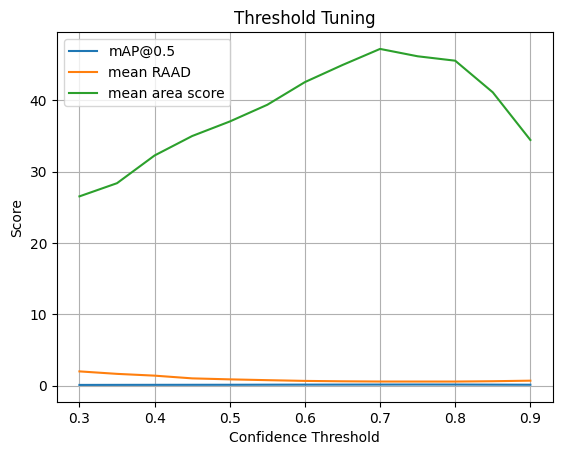

In [ ]:
conf_threshs = [r["conf_thresh"] for r in results]
mAPs = [r["mAP"] for r in results]
raad_means = [r["mean_RAAD"] for r in results]
#mean_area_scores = [r["mean_area_score"] for r in results]  # Add this line

plt.plot(conf_threshs, mAPs, label="mAP@0.5")
plt.plot(conf_threshs, raad_means, label="mean RAAD")
#plt.plot(conf_threshs, mean_area_scores, label="mean area score")  # Add this line
plt.xlabel("Confidence Threshold")
plt.ylabel("Score")
plt.title("Threshold Tuning")
plt.legend()
plt.grid(True)
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


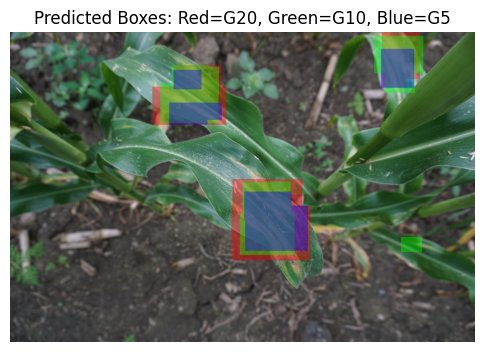

In [34]:
i = 10  # index of the image you want to visualize
img = Image.open(image_paths[i]).convert("RGB")

# Get predictions from each model
img_resized = img.resize((640, 640))
img_array = np.array(img_resized) / 255.0

pred_boxes_1, _ = decode_yolo_output(model_g20.predict(np.expand_dims(img_array, axis=0))[0], conf_thresh=0.7)
pred_boxes_2, _ = decode_yolo_output(model_g10.predict(np.expand_dims(img_array, axis=0))[0], conf_thresh=0.7)
pred_boxes_3, _ = decode_yolo_output(model_g5.predict(np.expand_dims(img_array, axis=0))[0], conf_thresh=0.7)

# Overlay each model's boxes in a different color
img_overlay = img.copy()
img_overlay = overlay_boxes_on_image(img_overlay, pred_boxes_1, color=(255, 0, 0), alpha=0.4)   # Red
img_overlay = overlay_boxes_on_image(img_overlay, pred_boxes_2, color=(0, 255, 0), alpha=0.4)   # Green
img_overlay = overlay_boxes_on_image(img_overlay, pred_boxes_3, color=(0, 0, 255), alpha=0.4)   # Blue

plt.figure(figsize=(6, 6))
plt.imshow(img_overlay)
plt.title("Predicted Boxes: Red=G20, Green=G10, Blue=G5")
plt.axis("off")
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


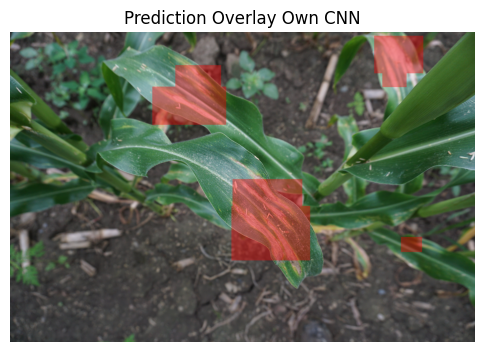

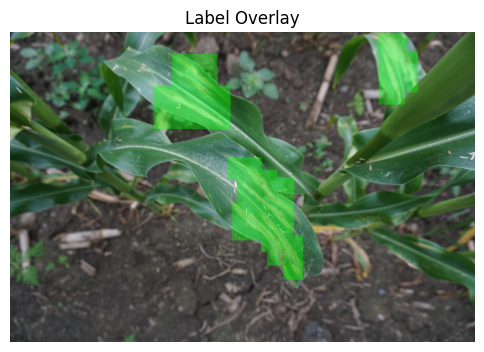

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


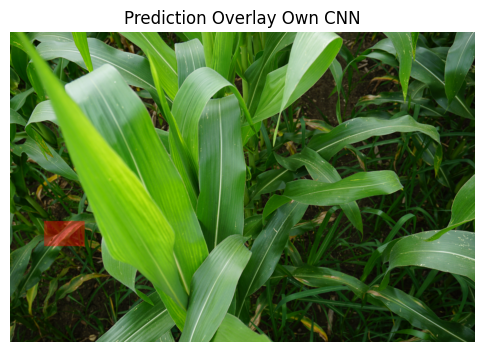

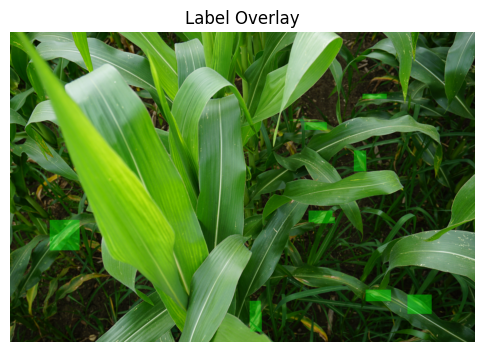

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step


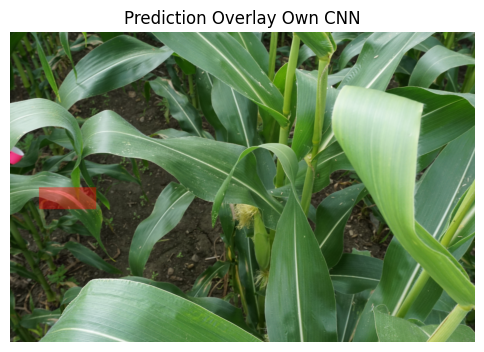

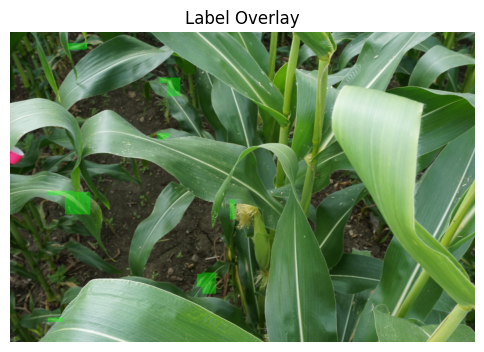

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step


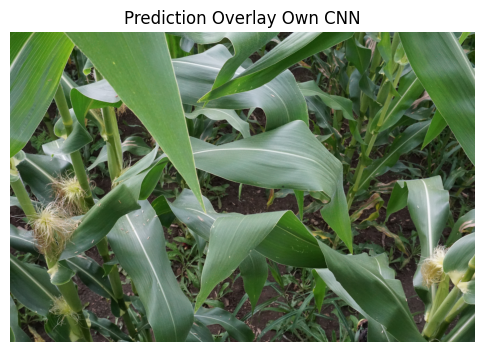

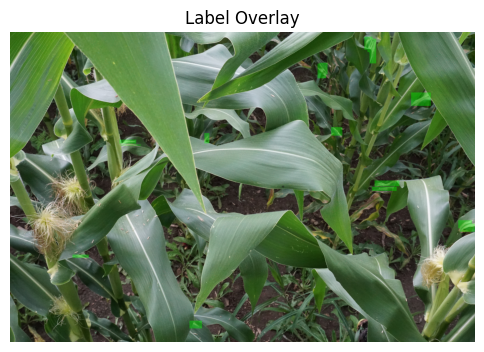

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step


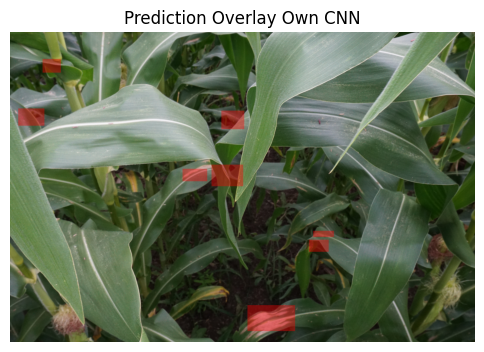

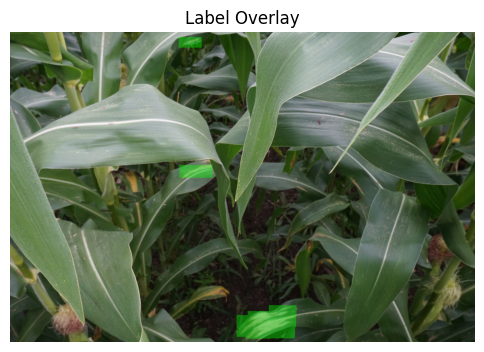

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


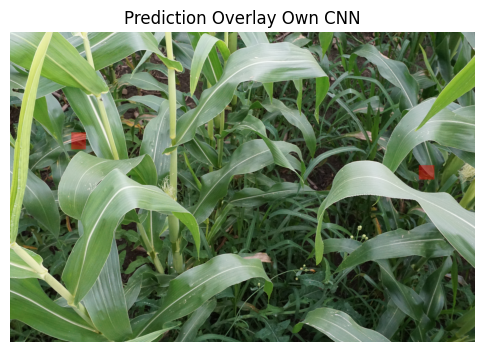

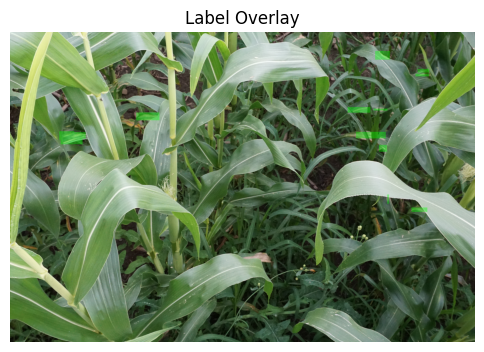

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step


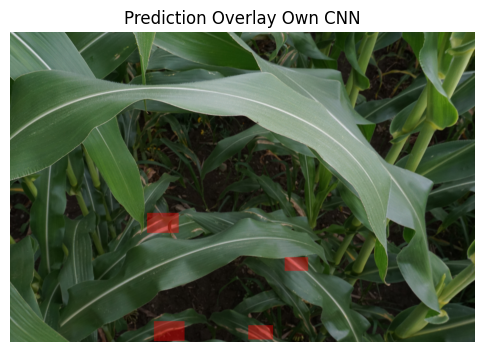

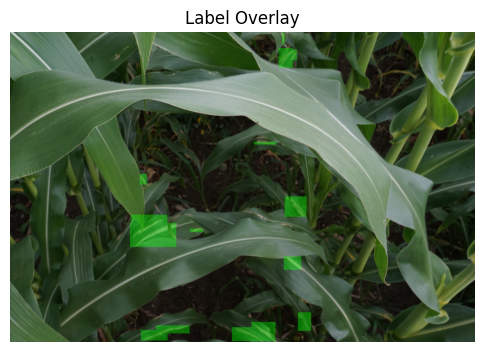

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


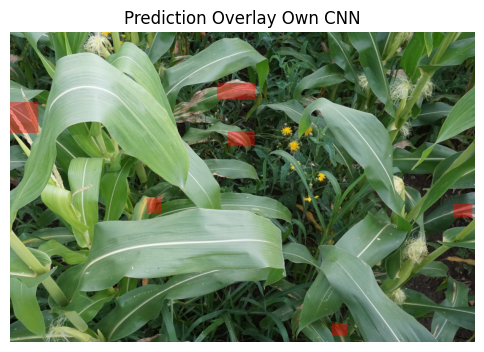

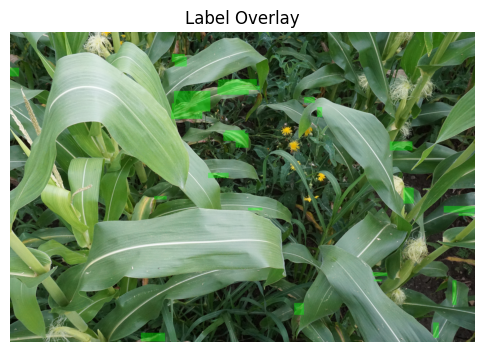

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step


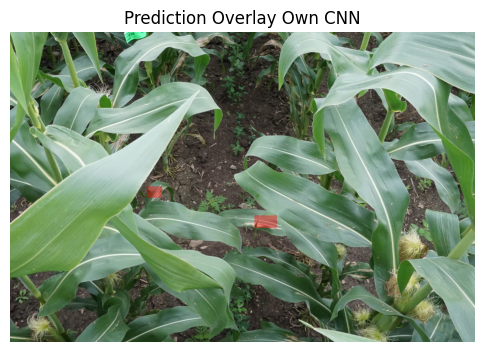

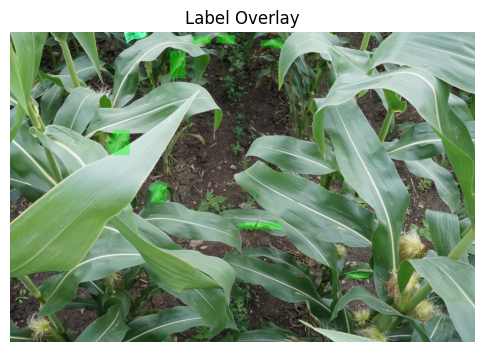

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


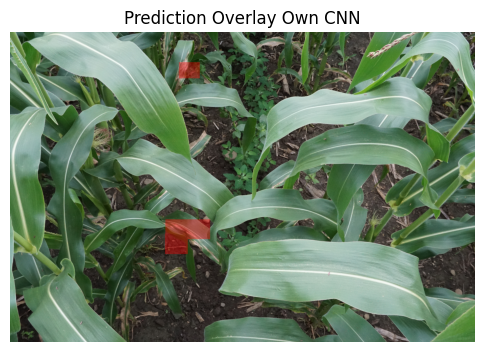

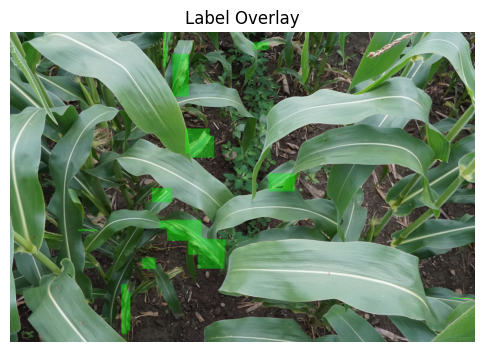

In [33]:
num_images = 20

image_paths = image_paths_raw[10:num_images]
gt_boxes_list = gt_boxes_list_raw[10:num_images]

for i, path in enumerate(image_paths):
    img = Image.open(path).convert("RGB")
    img_resized = img.resize((640, 640))
    img_array = np.array(img_resized) / 255.0

    models = [model_g20, model_g10, model_g5]
    final_boxes, final_scores = ensemble_three_models_on_image(models, img_array , conf_thresh=0.7)

    # Overlay prediction boxes in red
    pred_overlay = overlay_boxes_on_image(img, final_boxes, color=(255, 0, 0), alpha=0.4)
    plt.figure(figsize=(6, 6))
    plt.imshow(pred_overlay)
    plt.title("Prediction Overlay Own CNN")
    plt.axis("off")
    plt.show()

    # Overlay ground truth boxes in green
    gt_boxes = gt_boxes_list[i]
    label_overlay = overlay_boxes_on_image(img, gt_boxes, color=(0, 255, 0), alpha=0.4)
    plt.figure(figsize=(6, 6))
    plt.imshow(label_overlay)
    plt.title("Label Overlay")
    plt.axis("off")
    plt.show()

In [ ]:
for i in range(len(image_batch)):
    models = [model_g20, model_g10, model_g5]
    final_boxes, final_scores = ensemble_three_models_on_image(models, image_batch[i])
    draw_ensemble_boxes_on_image(original_images[i], final_boxes, color="purple", label="Ensemble")


NameError: name 'image_batch' is not defined